# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads the 5 files that contain the dataset and the checkpoint:


https://drive.google.com/open?id=1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh

https://drive.google.com/open?id=18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv

https://drive.google.com/open?id=1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz

https://drive.google.com/open?id=1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a

https://drive.google.com/open?id=1fZY-tP2MuUYCA7Ur0C0zGTfEBs1XswGQ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW3a')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)
MODEL_PATH = os.path.join(HOMEWORK_FOLDER, 'checkpoint.pth')
MASK_MODEL_PATH = os.path.join(HOMEWORK_FOLDER, 'checkpoint-mask.pth')

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
'1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh': 'hw3_mycocodata_bboxes_comp_zlib.npy',
'18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv': 'hw3_mycocodata_img_comp_zlib.h5',
'1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz': 'hw3_mycocodata_labels_comp_zlib.npy',
'1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a': 'hw3_mycocodata_mask_comp_zlib.h5',
'1fZY-tP2MuUYCA7Ur0C0zGTfEBs1XswGQ': 'checkpoint680.pth',
}

# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

Mounted at /content/gdrive


# Load Checkpoint
Here is some sample code to load the pretrained model we are providing

In [ ]:
import torchvision
import torch

def pretrained_model_680(checkpoint_file):

    import torchvision
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
    
    model.eval()
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    backbone = model.backbone
    rpn = model.rpn
    
    checkpoint = torch.load(checkpoint_file)
    
    backbone.load_state_dict(checkpoint['backbone'])
    rpn.load_state_dict(checkpoint['rpn'])
    
    return backbone, rpn


backbone,rpn = pretrained_model_680('checkpoint680.pth')
# print(backbone)
print(rpn)

E = torch.ones([1,3,800,1088], device='cuda')
backout = backbone(E)
print(len(backout))


from torchvision.models.detection.image_list import ImageList 
im_lis = ImageList(E, [(800,1088)])

rpn.eval()
rpnout = rpn(im_lis,backout)
print(rpnout)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 50.2MB/s]


RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)
5
([tensor([[  0.0000,   0.0000, 109.5224,  34.7064],
        [  0.0000,   0.0000, 198.6675,  69.8575],
        [  0.0000,   0.0000, 565.8075,  58.1282],
        ...,
        [596.0027, 738.8527, 675.9938, 800.0000],
        [580.0027, 738.8527, 659.9938, 800.0000],
        [564.0027, 738.8527, 643.9938, 800.0000]], device='cuda:0')], {})


# PyTorch Dataset

Copy your HW3a dataset code

In [ ]:
import torch
import torchvision
import h5py
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image
import random
from sklearn.metrics import average_precision_score
import colorsys
import gc
from torchvision.models.detection.image_list import ImageList 
from torchvision import ops
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

use_cuda = True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [ ]:
"""# Image Pre-processing"""

def preprocess(image, masks_per_img, bboxes_per_img):
    '''
    resize, pad and normalize
    parameters:
        image: np.array([3, 300, 400])
        masks: np.array(n_mask_per_image, 300, 400)
        bboxes: np.array(n_boxes_per_image, 4)
    returns:
        image_transformed: torch.tensor([3, 800, 1088])
        masks_transformed: torch.tensor([n_masks, 800, 1088])
        bbox_resized_pad: torch.tensor[n_boxes_per_image, 4]
    '''

    # Pre-process image, masks and bboxes
    img_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((800, 1066)),
        transforms.Pad((11, 0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    mask_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((800, 1066)),
        transforms.Pad((11, 0))
        ])

    # 1. Transform image
    img_np = np.transpose(image.astype(np.uint8), (1, 2, 0))
    image_transformed = img_transforms(img_np)

    # 2. Transform masks
    masks_transformed = torch.tensor([])
    for j in range(masks_per_img.shape[0]):
        mask = masks_per_img[j].astype(np.uint8)
        mask_transformed = torch.from_numpy(np.array(mask_transform(mask))).type(torch.float)
        mask_transformed = mask_transformed.unsqueeze(0)
        masks_transformed = torch.cat((masks_transformed, mask_transformed), dim=0)

    # 3. Transform bounding boxes
    bbox_resized = bboxes_per_img.copy()
    scale = 800 / 300
    bbox_resized[:,0:2] = bbox_resized[:,0:2] * scale
    bbox_resized[:, 2:] = bbox_resized[:,2:] * scale
    bbox_resized_pad = torch.from_numpy(bbox_resized + 11)

    return image_transformed, masks_transformed, bbox_resized_pad

In [ ]:
"""# PyTorch Dataset

Copy your HW3a dataset code
"""

class HW3Dataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.path = path
        self.bboxes = np.load(path[0], allow_pickle=True, encoding='latin1')
        self.images = h5py.File(path[1], 'r')['data']
        self.labels = np.load(path[2], allow_pickle=True, encoding='latin1')
        self.masks_original = h5py.File(path[3], 'r')['data']
        self.masks = []
        self.k = 0          # total masks in dataset
        gc.collect()

        '''
        # Itrate over all bounding boxes in the dataset
        # Divide elements in mask
        '''
        # iterate over each image
        for idx, bboxes_per_img in enumerate(self.bboxes):

            # iterate over each bbox
            for i in range(self.bboxes[idx].shape[0]):
                if i == 0:
                    mask = self.masks_original[self.k]
                    mask = np.expand_dims(mask, axis=0)
                else:
                    mask_cat = np.expand_dims(self.masks_original[self.k], axis=0)
                    mask = np.concatenate((mask, mask_cat), axis = 0)
                self.k += 1
                
            # Assign masks
            self.masks.append(mask)     # as a list


    def __len__(self):
        return self.images.shape[0]


    def __getitem__(self, index):
        if torch.is_tensor(index):
            index, _ = torch.sort(index)
            index = index.tolist()
            
        # Pre-process the images, masks and bounding boxes
        img_trans, mask_trans, bbox_trans = preprocess(self.images[index], self.masks[index], self.bboxes[index])
        data = {'image': img_trans, 
                'target': {'label': torch.from_numpy(self.labels[index]), 'bbox': bbox_trans, 
                           'mask': mask_trans}}
        return data


path = ["hw3_mycocodata_bboxes_comp_zlib.npy", 'hw3_mycocodata_img_comp_zlib.h5', 'hw3_mycocodata_labels_comp_zlib.npy', 'hw3_mycocodata_mask_comp_zlib.h5']
dataset = HW3Dataset(path)

i=1
print("image size before transformed: ", dataset.images[i].shape)   
print("image size after transformed: ", dataset[i]['image'].shape)
print("mask size after transformed: ", dataset[i]['target']['mask'].shape)
print("label size:", dataset[i]['target']['label'].shape)

image size before transformed:  (3, 300, 400)
image size after transformed:  torch.Size([3, 800, 1088])
mask size after transformed:  torch.Size([2, 800, 1088])
label size: torch.Size([2])


In [ ]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [ ]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [ ]:
def draw_bboxes(image, new_rpn, ax):
    '''
    image: tensor(3, 800, 1088)
    new_rpn: tensor[n, 9], n is the number of boxes on one image
    '''
    bboxes = new_rpn[:, :4]
    # label = new_rpn[:, 4]
    label = new_rpn[:, 3]
    image = np.transpose(image.numpy(), (1, 2, 0))
    image_convert = (image - image.min()) * (1/(image.max() - image.min()) * 255)
    ax.imshow(image_convert.astype(np.uint8))
    
    for i in range(bboxes.shape[0]):
        # Bounding box
        x1, y1, x2, y2 = bboxes[i,:]
        w = x2 - x1
        h = y2 - y1

        if label[i] > 0:
            color = 'r'
        else:
            color = 'g'

        # ax = plt.gca()
        rect = patches.Rectangle((x1,y1),w,h,linewidth=2,edgecolor=color,facecolor='none')
        ax.add_patch(rect)

In [ ]:
def display_instance(data, plt, scores=None, masks=None, labels=None, image=None, boxes=None):
    '''
    data: 1*{'image', 'target'}
    masks: [100, 800, 1088]
    '''
    if data:
        image = data['image'].numpy()
        image = np.transpose(image, (1, 2, 0))
        boxes = data['target']['bbox'].numpy()
        masks = data['target']['mask'].numpy() 
        labels = data['target']['label'].numpy()

    else:
        image = np.transpose(image.cpu().numpy(), (1, 2, 0))
        boxes = boxes.cpu().numpy()
        masks = masks.cpu().numpy()
        labels = labels.cpu().numpy()
    
    class_names = {1: "vehicle", 2: 'people', 3: 'animal'}
    
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[0] == labels.shape[0]

    # Generate random colors
    colors = random_colors(N)

    image_convert = (image - image.min()) * (1/(image.max() - image.min()) * 255)
    masked_image = image_convert.astype(np.uint32).copy()

    # Plot bounding boxes
    for i in range(N):
        color = colors[i]
        # Bounding box
        x1, y1, x2, y2 = boxes[i,:]
        w = x2 - x1
        h = y2 - y1

        if labels[i] == 1:    # vehicles
            # continue
            color_box = 'r'
        elif labels[i] == 2:
            color_box = 'b'
            # elif labels[i] == 2:  # people
            #     color_box = 'b'  
        elif labels[i] == 3:  # animals
            color_box = 'g'

        ax = plt.gca()
        rect = patches.Rectangle((x1,y1),w,h,linewidth=2,edgecolor=color_box,facecolor='none')
        ax.add_patch(rect)

        # Label
        label = labels[i]
        score = scores[i] if scores is not None else None
        label_name = class_names[label]
        caption = "{} {:.3f}".format(label_name, score) if score else label_name
        ax.text(x1, y1, caption, color='w', size=12, backgroundcolor="black")
        # ax.text(x1, y1, caption,
        #         color='w', size=12, backgroundcolor="b")


        # Mask
        mask = masks[i].astype(np.uint32)
        masked_image = apply_mask(masked_image, mask, color)

        ax.imshow(masked_image.astype(np.uint8))
    
    plt.show()

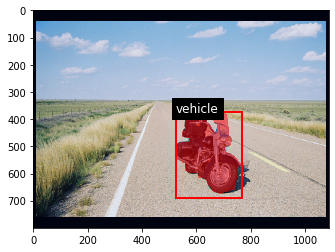

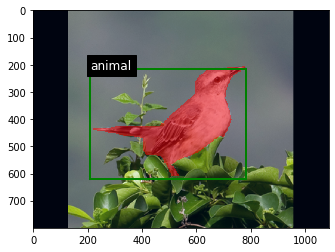

In [ ]:
for i in range(199, 201):
    plt.figure(i)
    data = dataset[i]
    display_instance(data, plt)

In [ ]:
def compute_iou(boxA, boxB):
    '''
    compute IOU of two boxes
    box1, box2:(x1, y1, x2, y2)
    '''

    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [ ]:
def assign_gt_labels(rpnout, bboxes, labels, iou=0.5):
    '''
    For each proposal find the IOU with the ground truth boxes. 
    1) If IOU is smaller than let's say 0.5 you can consider this background. 
    If it is >0.5 this proposal is assigned the label of the corresponding bounding box 
    for the classifier (and the coordinates for the regressor). 
    2) The proposal that has the maximum IOU with a bounding box is assigned 
    by this bounding box as target. 
    params:
        rpnout: torch.tensor([1000, 4]) in form of [x1,y1,x2,y2]
        bboxes: torch.tensor([n_boxes, 4]) in form of [x1,y1,x2,y2]
        labels: torch.tensor(n_boxes)
    return:
        new_proposals: torch.tensor([1000, 9]) in form of [x1, y1, x2, y2, gt_label, gt_x1, gt_y1, gt_x2, gt_y2]
    '''
    rpn_num = rpnout.shape[0]   # 1000
    n_bbox = bboxes.shape[0]    # number of boxes
    iou_max = [0.0] * n_bbox
    iou_max_idx = [0] * n_bbox
    new_proposals = torch.tensor([]).to(device)
    
    # iterate over each rpn output 
    for i in range(rpn_num):
        rpn = rpnout[i].clone()
        new_rpn = torch.zeros(9,).to(device)
        new_rpn[:4] = rpn
        # compare with every ground truth bbox
        non_iou_count = 0
        for bbox_idx, bbox in enumerate(bboxes):

            # compute the IOU of ground truth box and rpn box
            iou = compute_iou(bbox, rpn)

            # if iou>0.5, assign the label and coordinates
            if iou >= 0.5:
                new_rpn[4] = labels[bbox_idx]
                new_rpn[5:] = bbox

            # keep track of the highest IOU of that bounding box
            if iou > iou_max[bbox_idx]:
                iou_max[bbox_idx] = iou
                iou_max_idx[bbox_idx] = i

        new_proposals = torch.cat((new_proposals, new_rpn.unsqueeze(0)), dim=0)

    # After iterate all rpn boxes, assign the max iou
    for bbox_idx, bbox in enumerate(bboxes):
        new_proposals[iou_max_idx[bbox_idx], 4] = labels[bbox_idx]
        new_proposals[iou_max_idx[bbox_idx], 5:] =  bbox

    # print("shape of new proposals: ", new_proposals.shape)
    return new_proposals


In [ ]:
def subsample(new_rpn, equal=False):
    '''
    After this assignment subsample negative (background) and positive regions 
    in a ratio as close to 1:1 as possible.
    params:
        new_rpn: torch.tensor([1000, 9]) in form of [x1, y1, x2, y2, gt_label, gt_x1, gt_y1, gt_x2, gt_y2]
        equal: True to subsample 1:1, False to subsmaple to 128
    returns:
        subsampled tensors
    '''
    if new_rpn.shape[1] > 4:
        # positive and negative masks
        positive_idx = torch.where(new_rpn[:, 4] > 0)      # label > 0
        positive_num = positive_idx[0].shape[0]
        # print("number of positives: ", positive_num)
        negative_idx = torch.where(new_rpn[:, 4] == 0)
        
        # subsample negative indices to 1:1 or 128 batch size
        if equal:
            sampled_idx_idx = random.sample(range(negative_idx[0].shape[0]), positive_num)
        else:
            sampled_idx_idx = random.sample(range(negative_idx[0].shape[0]), 128 - positive_num)

        sampled_neg_idx = negative_idx[0][sampled_idx_idx]
        # print("negative number: ", sampled_neg_idx.shape[0])
        
        sampled_idx = torch.cat((positive_idx[0], sampled_neg_idx))
        # print("total size: ", sampled_idx.shape)
        sorted, _ = torch.sort(sampled_idx)
        sampled_rpn = new_rpn[sorted]

    else:
        # positive and negative masks
        positive_idx = torch.where(new_rpn > 0)      # label > 0
        positive_num = positive_idx[0].shape[0]
        print("number of positives: ", positive_num)
        negative_idx = torch.where(new_rpn == 0)
        
        # subsample negative indices to 1:1 or 128 batch size
        if equal:
            sampled_idx_idx = random.sample(range(negative_idx[0].shape[0]), positive_num)
        else:
            sampled_idx_idx = random.sample(range(negative_idx[0].shape[0]), 128 - positive_num)

        sampled_neg_idx = negative_idx[0][sampled_idx_idx]
        print("negative number: ", sampled_neg_idx.shape[0])
        
        sampled_idx = torch.cat((positive_idx[0], sampled_neg_idx))
        # print("total size: ", sampled_idx.shape)
        sorted, _ = torch.sort(sampled_idx)
        sampled_rpn = new_rpn[sorted]

    return sampled_rpn

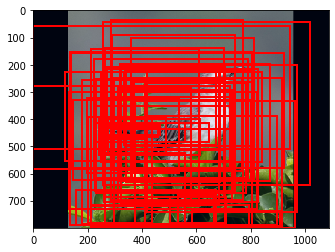

In [ ]:
def prepare_data(data, RPN_plot=False, ROI_plot=False):
    '''
    The mask loss Lmask is defined only on
    positive RoIs. The mask target is the intersection between
    an RoI and its associated ground-truth mask.
    We produce one mask for each class.

    returns:
        rpn_aligned_unroll: [sampled_rpns, 256*7*7]
        rpn_result: [sampled_rpns, 9] in form of torch.tensor[x1, y1, x2, y2, label, gt_x1, gt_y1, gt_x2, gt_y2]
        p2: p2 from RPN network, [1, 256, h/4, w/4]
    '''

    image = data['image'].unsqueeze(0).to(device)      # image as a FloatTensor with size (n_batch, 3, 800, 1088)
    targets = data['target']
    masks = targets['mask'].to(device)
    bboxes = targets['bbox'].to(device)
    labels = targets['label'].to(device)

    #########################
    # Prepare for box model #
    #########################
    # Get feature P2
    for param in backbone.parameters():                 # freeze the weights
        param.requires_grad = False
    backout = backbone(image)
    p2 = backout[0]                                     # p2: [1, 256, h/4, w/4]

    # Get rpn output
    im_lis = ImageList(image, [(800,1088)])
    rpn.eval()
    for param in rpn.parameters():                      # freeze the weights
        param.requires_grad = False
    rpnout = rpn(im_lis,backout)                        # rpnout[0][0] is size(1000, 4)
    proposals = rpnout[0][0]

    # Assign ground truth bbox and label to positive rpns
    new_rpn = assign_gt_labels(proposals, bboxes, labels)   # [num_rpns, 9]

    # Subsample assigned rpns to 128 
    rpn_result = subsample(new_rpn, False)              # [sampled_rpns, 9]

    ## Visualization
    # Plot some proposals
    if RPN_plot:
        fig = plt.figure(i)   
        ax = fig.add_subplot(1, 1, 1)    
        draw_bboxes(image.squeeze().cpu(), rpn_result[:50], ax)

    if ROI_plot:
        n_cols = 5
        fig = plt.figure(i, figsize=(60, 60))
        ax1 = fig.add_subplot(1,n_cols,1)        
        draw_bboxes(image.squeeze().cpu(), rpn_result, ax1)

    # Roi Align
    rpn_boxes = rpn_result[:, :4]                       # in image coordinate
    roi_align = ROIAlign()
    aligned = roi_align(p2, [rpn_boxes/4], [7,7])       # [sampled_rpns, 256, 7, 7]
    
    ## Visualization
    # Plot some croped image after Roi Align
    if ROI_plot:
        aligned_image = roi_align(image, [rpn_boxes], [50,50])
        for j in range(2, 6):
            image_show = aligned_image[j-2].squeeze().cpu()
            image_convert = (image_show - image_show.min()) * (1/(image_show.max() - image_show.min()) * 255)
            ax2 = fig.add_subplot(1, n_cols, j)
            ax2.imshow(image_convert.permute(1,2,0).type(torch.uint8))

    # Unroll roi output into a C*P*P vector
    N = aligned.shape[0]
    rpn_aligned_unroll = aligned.view(N, -1)            # [sampled_rpns, 256*7*7]


    ##########################
    # Prepare for mask model #
    ##########################

    target = torch.zeros(4, 28, 28).to(device)
    label_once = []
    # crop mask as bbox
    for idx in range(bboxes.shape[0]):

        # only use the first occurred label
        label = labels[idx]
        if label in label_once:                             
            continue
        label_once.append(label)

        x1, y1, x2, y2 = bboxes[idx].type(torch.int)        # bbox [4,]
        mask = masks[idx]                                   # mask [800, 1088]
        mask_cropped = mask[y1:y2, x1:x2]                  
        mask_unsquez = mask_cropped.unsqueeze(0)
        mask_unsquez = mask_unsquez.unsqueeze(0)

        # Resize cropped mask to 28 * 28
        mask_resized = F.interpolate(mask_unsquez, (28, 28), mode='bilinear', align_corners=True)   # [1, 1, 28, 28]
        positive_mask = torch.where(mask_resized > 0)
        mask_resized[positive_mask] = 1
        target[label] = mask_resized.squeeze()

    mask_target = target.unsqueeze(0).expand(100, -1, -1, -1)
    return rpn_aligned_unroll, rpn_result, p2, mask_target  # rpn_result:[sampled_rpns, 9]
# for jj in range(1):
aa,bb,cc,dd = prepare_data(dataset[200],True,False)
# print(type(prepare_data(dataset[200],False,False)))
# print(np.size(prepare_data(dataset[200],False,False)))


# Model Definition

Define the four models

In [ ]:
class ROIAlign(torch.nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, rpn_out, boxes, size=7):
    output = ops.roi_align(rpn_out, boxes, size)
    return output 
    # def forward(self, X):
    #   return None

class Boxes(torch.nn.Module):
  def __init__(self):
    super().__init__()
    # Interlayer
    self.fc1 = nn.Linear(in_features=7*7*256, out_features=1024)
    self.fc2 = nn.Linear(in_features=1024, out_features=1024)

    # Classifier
    self.fc3 = nn.Linear(in_features=1024, out_features=4)

    # Regressor
    self.fc4 = nn.Linear(in_features=1024, out_features=4*4)

  def forward(self, x):
    # Interlayer
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    # Classifier
    mrcnn_probs = F.softmax(self.fc3(x), dim=1)

    # Regressor
    mrcnn_bbox = self.fc4(x)

    return [mrcnn_probs, mrcnn_bbox]

class Classifier(torch.nn.Module):
  def __init__(self):
    super().__init__()
    
  def forward(self, X):
    return None

class Regressor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    
  def forward(self, X):
    return None

class Masks(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    # self.bn1 = nn.BatchNorm2d(256, eps=0.001)
    self.conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    # self.bn2 = nn.BatchNorm2d(256, eps=0.001)
    self.conv3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    # self.bn3 = nn.BatchNorm2d(256, eps=0.001)
    self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    # self.bn4 = nn.BatchNorm2d(256, eps=0.001)
    self.deconv = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
    self.conv6 = nn.Conv2d(256, 4, kernel_size=1)
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU(inplace=True)
      
  def forward(self, x):
    x = self.conv1(x)
    # x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    # x = self.bn2(x)
    x = self.relu(x)

    x = self.conv3(x)
    # x = self.bn3(x)
    x = self.relu(x)

    x = self.conv4(x)
    # x = self.bn4(x)
    x = self.relu(x)

    x = self.deconv(x)
    x = self.relu(x)

    x = self.conv6(x)
    x = self.sigmoid(x)
    return x


# Train your network

It might be good to save checkpoints and reload from the most recent. This is due to time constraints inside of colab.

In [ ]:
def encode_boxes(gt_boxes, rpn_boxes, labels):
    '''
    Create the encoding t* of the ground truth boxes with respect to the proposals
    Ground truth boxes are encoded into t∗ vectors and its values are relative to 
    their corresponding proposal.
    t_x = (x − x_a)/w_a 
    t_y = (y − y_a)/h_a 
    t_w = log(w/w_a) 
    t_h = log(h/h_a)
    x/y, x_a/y_a are top-left corner of boxes
    params:
        gt_boxes: [sampled_rpns, 4]
        rpn_boxes: [sampled_rpns, 4]
        labels: [sampled_rpns, ]
    returns:
        gt: [sampled_rpns, 4*4]
    '''

    # Parameterize
    w_a = rpn_boxes[:, 2] - rpn_boxes[:, 0]
    h_a = rpn_boxes[:, 3] - rpn_boxes[:, 1]
    w_gt = gt_boxes[:, 2] - gt_boxes[:, 0] + 0.0000001
    h_gt = gt_boxes[:, 3] - gt_boxes[:, 1] + 0.0000001
    t_x = (gt_boxes[:, 0] - rpn_boxes[:, 0]) / w_a      # [sampled_rpns, ]
    t_y = (gt_boxes[:, 1] - rpn_boxes[:, 1]) / h_a
    t_w = torch.log(w_gt / w_a)
    t_h = torch.log(h_gt / w_a)
    t_vector = torch.cat((t_x.unsqueeze(-1), t_y.unsqueeze(-1), t_w.unsqueeze(-1), t_h.unsqueeze(-1)), dim=-1)

    gt = torch.zeros(gt_boxes.shape[0], 4, 4).to(device)
    index = torch.LongTensor(range(gt_boxes.shape[0]))
    gt[(index, labels)] = t_vector
    gt = gt.view(-1, 4*4)
    return gt

In [ ]:
def decode_boxes(reg_out, rpn_boxes):
    '''
    Decode regressor outputs from t-vectors form to image coordinates form
    t_x = (x − x_a)/w_a 
    t_y = (y − y_a)/h_a 
    t_w = log(w/w_a) 
    t_h = log(h/h_a)
    x/y, x_a/y_a are top-left corner of boxes
    params:
        reg_out: [sampled_rpns, 4*4]
        rpn_boxes: [sampled_rpns, 4]
    returns:
        boxes: [sampled_rpns, 4, 4]
    '''
    x_a = rpn_boxes[:, 0].unsqueeze(-1).expand(-1, 4)
    y_a = rpn_boxes[:, 1].unsqueeze(-1).expand(-1, 4)
    w_a = (rpn_boxes[:, 2] - rpn_boxes[:, 0]).unsqueeze(-1).expand(-1, 4)
    h_a = (rpn_boxes[:, 3] - rpn_boxes[:, 1]).unsqueeze(-1).expand(-1, 4)

    reg_out = reg_out.view(-1, 4, 4)
    x1 = reg_out[:,:, 0] * w_a + x_a
    y1 = reg_out[:,:, 1] * h_a + y_a
    w = w_a * torch.exp(reg_out[:,:,2])
    h = h_a * torch.exp(reg_out[:,:,3])

    x2 = x1 + w
    y2 = y1 + h
    
    boxes = torch.cat((x1.unsqueeze(-1), y1.unsqueeze(-1), x2.unsqueeze(-1), y2.unsqueeze(-1)), dim=-1)
    return boxes

In [ ]:
"""## Train Box Classifier & Regressor"""

# losses
classifier_loss = nn.BCELoss()
def regressor_loss(reg_out, reg_target, labels):
    '''
    Compute smooth_L1_loss for positive rois
    params:
        reg_out, reg_target: [sampled_rpns, 4*4]
        labels: [sampled_rpns,]
    '''
    l1_loss = nn.SmoothL1Loss()

    # Only positive ROIs contribute to the loss.
    positive_idx = torch.where(labels > 0)
    positive_target = reg_target[positive_idx[0], :]
    positive_out = reg_out[positive_idx[0], :]

    # Smooth L1 loss
    loss = l1_loss(positive_target, positive_out)
    return loss

In [ ]:
# Train for Box Head
epochs = 10
step = 20
num_iter = 0
train_test_ratio = 0.8
class_losses, regss_losses, total_losses, iterations = [], [], [], []

# Models
box_model = Boxes().to(device)

# optimizer
optimizer = optim.Adam(box_model.parameters(), lr=0.0001)

# Start training
for epoch in range(epochs):
    class_loss_total = 0.0
    regss_loss_total = 0.0

    # iterate over each image
    # batch size is 128
    start = time.time()
    for i in range(int(train_test_ratio * len(dataset))):
        # if i > 5:
        #     break
        data = dataset[i]
        x, target, p2, _ = prepare_data(data)                       # x: [sampled_rpns, 256*7*7], target: [sampled_rpns, 9]
        
        # Encode labels
        labels = target[:, 4].type(torch.long)
        labels_one_hot = F.one_hot(labels, 4)

        # Encode boxes to t* vectors
        gt_boxes = target[:, 5:]
        rpn_boxes = target[:, :4]
        boxes_encoded = encode_boxes(gt_boxes, rpn_boxes, labels)   # [sampled_rpns, 4*4]
        
        # Model outputs
        cls_out, reg_out = box_model(x)                             # cls_out: [sampled_rpns, 4], reg_out: [sampled_rpns, 4*4]

        # Loss
        cls_loss = classifier_loss(cls_out, labels_one_hot.type(torch.float))
        
        reg_loss = regressor_loss(reg_out, boxes_encoded, labels)

        class_loss_total += cls_loss.item()
        regss_loss_total += reg_loss.item()

        # backward
        optimizer.zero_grad()
        (cls_loss + reg_loss).backward()
        optimizer.step()

        if (i+1) % step == 0:
            end = time.time()
            print ('Epoch [{}/{}], Step [{}/{}], Classifier Loss: {:.4f}, Regressor loss: {:.4f}, Time elapsed: {:.4f}'.format(epoch+1, 
                                epochs, i+1, int(train_test_ratio*len(dataset)), class_loss_total / (i+1), regss_loss_total / (i+1), end-start))
            class_losses.append(class_loss_total / (i+1))
            regss_losses.append(regss_loss_total / (i+1))
            total_losses.append(class_loss_total / (i+1) + regss_loss_total / (i+1))
            iterations.append(num_iter)

        num_iter += 1
        torch.save(box_model.state_dict(), MODEL_PATH)

Epoch [1/10], Step [20/2612], Classifier Loss: 0.2762, Regressor loss: 0.0281, Time elapsed: 27.7284
Epoch [1/10], Step [40/2612], Classifier Loss: 0.2266, Regressor loss: 0.0267, Time elapsed: 51.8984
Epoch [1/10], Step [60/2612], Classifier Loss: 0.2178, Regressor loss: 0.0271, Time elapsed: 78.7710
Epoch [1/10], Step [80/2612], Classifier Loss: 0.1963, Regressor loss: 0.0258, Time elapsed: 102.5474
Epoch [1/10], Step [100/2612], Classifier Loss: 0.1781, Regressor loss: 0.0254, Time elapsed: 127.2575
Epoch [1/10], Step [120/2612], Classifier Loss: 0.1708, Regressor loss: 0.0242, Time elapsed: 153.0465
Epoch [1/10], Step [140/2612], Classifier Loss: 0.1610, Regressor loss: 0.0235, Time elapsed: 178.8794
Epoch [1/10], Step [160/2612], Classifier Loss: 0.1604, Regressor loss: 0.0226, Time elapsed: 205.3702
Epoch [1/10], Step [180/2612], Classifier Loss: 0.1552, Regressor loss: 0.0218, Time elapsed: 228.4437
Epoch [1/10], Step [200/2612], Classifier Loss: 0.1504, Regressor loss: 0.0211, 

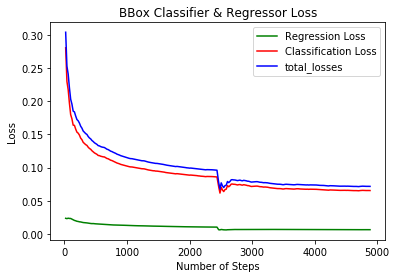

In [ ]:
# plt.figure(1)
# plt.plot(iterations, class_losses)
# plt.xlabel("iterations")
# plt.ylabel("classification loss")
# plt.title("train loss (classifier) - iteration")

# plt.figure(2)
# plt.plot(iterations, regss_losses)
# plt.xlabel("iterations")
# plt.ylabel("regression loss")
# plt.title("train loss (regressor) - iteration")

# plt.figure(3)
# plt.plot(iterations, total_losses)
# plt.xlabel("iterations")
# plt.ylabel("total loss")
# plt.title("train loss (total) - iteration")
plt.title('BBox Classifier & Regressor Loss')
plt.plot(iterations,regss_losses, color='green',label='Regression Loss')
plt.plot(iterations, class_losses, color='red',label = 'Classification Loss')
plt.plot(iterations, total_losses, color='blue',label='total_losses')
plt.legend()
plt.xlabel('Number of Steps')
plt.ylabel("Loss")

plt.show()

In [ ]:
"""## Post processing of Box Head"""

def postProcess(reg_out, rpn_boxes, cls_out):
    '''
    1. Decoding the regressor output from t vector to boxes coordinates
    2. Remove invalid boxes (empty and cross boundary)
    3. Apply nms with iou=0.5 (independently for each class, except background)
    4. If the detections are many (usually 100 are enough),
       sort them by some confidence criterion and remove the rest
    params:
        reg_out: [sampled_rpns, 4, 4]
        rpn_boxes: [sampled_rpns, 4]
        cls_out: [sampled_rpns, 4]
    returns:
        keep_top100: tensor[100, 6] in form of [x1,y1,x2,y2,score,class]
    '''
    # Decode the regressor output
    regout_decoded = decode_boxes(reg_out, rpn_boxes)           # [sampled_rpns,4,4]

    # Remove empty and cross boundary boxes
    idx_negative = torch.where(regout_decoded < 0)
    regout_decoded[idx_negative[0], idx_negative[1]] = -1

    idx_x1_cross = torch.where(regout_decoded[:,:,0] > 1088)
    regout_decoded[idx_x1_cross[0], idx_x1_cross[1]] = -1

    idx_x2_cross = torch.where(regout_decoded[:,:,2] > 1088)
    regout_decoded[idx_x2_cross[0], idx_x2_cross[1]] = -1

    idx_y1_cross = torch.where(regout_decoded[:,:,1] > 800)
    regout_decoded[idx_y1_cross[0], idx_y1_cross[1]] = -1

    idx_y2_cross = torch.where(regout_decoded[:,:,3] > 800)
    regout_decoded[idx_y2_cross[0], idx_y2_cross[1]] = -1

    # print(regout_decoded)

    keep = torch.tensor([]).to(device)
    for i in range(1, 4):
        regout_per_cls = regout_decoded[:, i]                   # [sampled_rpns, 4]
        regout_positive = torch.where(regout_per_cls[:, 0] > -1)
        boxes_per_cls = regout_per_cls[regout_positive[0]]      # [N, 4]
        scores_per_cls = cls_out[:, i]
        scores_per_cls = scores_per_cls[regout_positive[0]]

        # Apply nms for each class
        keep_idx = ops.nms(boxes_per_cls, scores_per_cls, 0.5)

        keep_boxes = boxes_per_cls[keep_idx]
        keep_scores = scores_per_cls[keep_idx]
        keep_box_score = torch.cat((keep_boxes, keep_scores.unsqueeze(-1)), dim=-1)   # [N_nms, 5]
  
        cls = torch.tensor([[i]]).type(torch.float).to(device)
        cls = cls.expand_as(keep_scores.unsqueeze(-1))
        keep_cls = torch.cat((keep_box_score, cls), dim=-1)     # [N_nms, 6] as [x1,y1,x2,y2,score,class]
        keep = torch.cat((keep, keep_cls), dim=0)
        
    # The maximum detections combined for all classes in a image
    # Find the top 100 boxes with scores
    _, idx_sorted = torch.sort(keep[:, 4], descending=True)
    keep_sorted = keep[idx_sorted]
    keep_top100 = keep_sorted[:100]
   
    return keep_top100

In [ ]:
"""## Test Box Classifier/Regressor"""
import math
# Load model
box_model_val = Boxes().to(device)
box_model_val.eval()

checkpoint = torch.load(MODEL_PATH)
box_model_val.load_state_dict(checkpoint)

total_mAP = 0
plot = True
pre_list = []
recall_list = []
map_list = []
with torch.no_grad():

    for i in range(int(0.75 * len(dataset)), len(dataset)):
        # if i > int(0.7 * len(dataset)) + 5:
        #     break
        data = dataset[i]
        image = data['image']
        x, target, p2, _ = prepare_data(data) 
        rpn_boxes = target[:, :4]

        cls_out, reg_out = box_model_val(x)

        keep = postProcess(reg_out, rpn_boxes, cls_out)     # [100, 6]

        gt_label = data['target']['label'].to(device)
        gt_boxes = data['target']['bbox'].to(device)
        gt_scores = []

        # Compute average precision
        for keep_idx in range(100):
            output = keep[keep_idx]                         # [x1,y1,x2,y2,score,class]
            label = output[5]
            # get the ground truth label for each kept proposal
            for box_idx in range(gt_boxes.shape[0]):
                if label == gt_label[box_idx]:
                    iou = compute_iou(gt_boxes[box_idx], output[:4])
                    if iou >= 0.3:
                        gt_scores.append(1)

            if (keep_idx + 1) > len(gt_scores):
                gt_scores.append(0)

        scores = keep[:, 4].cpu().numpy()
        gt_scores = np.array(gt_scores)
        mAP = average_precision_score(gt_scores, scores)
        map_list.append(mAP)
        if (i+1) % 10 == 0:
            # print("mAP of {}: {}".format(i, mAP))
            print("MAP value of {}th testing case: {}".format(i - int(0.75 * len(dataset) - 163*2),mAP))
        if np.isnan(mAP):
            continue
        total_mAP += mAP
        

        # Get each class's AP/recall
        for cls in range(1, 4):
            cls_idx = torch.where(keep[:, 5] == cls)
            scores = keep[cls_idx[0]][:, 4].cpu().numpy()
            gt_score = gt_scores[cls_idx[0].cpu().numpy()]
            precision, recall, _ = precision_recall_curve(gt_score, scores)
            pre_mean = sum(precision)/len(precision)
            recall_mean = sum(recall)/len(recall)
            if pre_mean == 0.5:
              pre_mean = 1.0
            if math.isnan(recall_mean):
              recall_mean = 0.0
            pre_list.append(pre_mean)
            recall_list.append(recall_mean)

            # print("precision: {}".format(pre_mean))
            # print("recall: {}".format(recall_mean))
        if i == len(dataset):
          print("##############")
          print("Finish")
          print("###############")
        if plot:
            if i < 10:
                plt.figure(i)      
                draw_reg_out(image.squeeze().cpu(), keep[:20, :4], keep[:20, 5], plt)

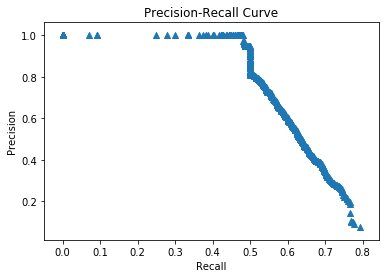

In [ ]:
# plot of  PR curve:
sorted_recall = sorted(recall_list)
sorted_pre = sorted(pre_list,reverse=True)
plt.scatter(sorted_recall, sorted_pre, marker='^')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

817


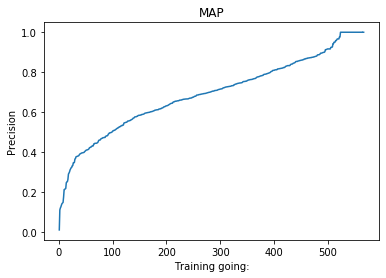

In [ ]:
# Plot of MAP curve
sorted_map_list = sorted(map_list)
print(len(sorted_map_list))
plt.plot(range(len(sorted_map_list[250:])),sorted_map_list[250:])
plt.title('MAP')
plt.xlabel('Training going:')
plt.ylabel('Precision')
plt.show()

In [ ]:
print("Mean Average Precision over all classes: ", total_mAP / ( len(dataset) - int(0.7 * len(dataset))))

Mean Average Precision over all classes:  0.6598753494860968


In [ ]:
def draw_reg_out(image, boxes, labels, plt):
    '''
    image: tensor(3, 800, 1088)
    boxes: [n, 4] as form of  [x1,y1,x2,y2]
    labels: [n, ]
    '''

    image = np.transpose(image.numpy(), (1, 2, 0))
    image_convert = (image - image.min()) * (1/(image.max() - image.min()) * 255)
    plt.imshow(image_convert.astype(np.uint8))
    
    for i in range(boxes.shape[0]):
        # Bounding box
        x1, y1, x2, y2 = boxes[i,:]
        w = x2 - x1
        h = y2 - y1

        if labels[i].item() == 1.0:     # 1: vehicle
            color = 'r'
        elif labels[i].item() == 2.0:   # 2: person
            color = 'g'
        else:                           # 3: animal
            color = 'b'

        ax = plt.gca()
        rect = patches.Rectangle((x1,y1),w,h,linewidth=2,edgecolor=color,facecolor='none')
        ax.add_patch(rect)

In [ ]:
"""## Train Mask Model"""

# Train for Box Head
epochs = 10
step = 20
num_iter = 0
train_test_ratio = 0.7
class_losses, regss_losses, masks_losses, total_losses, iterations = [], [], [], [], []

# Models
box_model = Boxes().to(device)
mask_model = Masks().to(device)

# optimizer
optimizer_box = optim.Adam(box_model.parameters(), lr=0.0001)
optimizer_mask = optim.Adam(mask_model.parameters(), lr=0.0001)

# Loss
compute_mask_loss = nn.BCELoss()

# Start training
for epoch in range(epochs):
    class_loss_total = 0.0
    regss_loss_total = 0.0
    masks_loss_total = 0.0

    # iterate over each image
    # batch size is 128
    start = time.time()
    for i in range(int(train_test_ratio * len(dataset))):
        # if i > 1:
        #     break
        data = dataset[i]
        x, target, p2, mask_target = prepare_data(data)             # x: [sampled_rpns, 256*7*7], target: [sampled_rpns, 9]
        # Encode labels
        labels = target[:, 4].type(torch.long)
        labels_one_hot = F.one_hot(labels, 4)

        # Encode boxes to t* vectors
        gt_boxes = target[:, 5:]
        rpn_boxes = target[:, :4]
        boxes_encoded = encode_boxes(gt_boxes, rpn_boxes, labels)   # [sampled_rpns, 4*4]
        
        # Box Model
        cls_out, reg_out = box_model(x)                             # cls_out: [sampled_rpns, 4], reg_out: [sampled_rpns, 4*4]
        keep = postProcess(reg_out, rpn_boxes, cls_out)             # [100, 6]

        # Mask model
        detections = keep[:, :4]                                    # [100, 4] in image coordinates
        roi_align = ROIAlign()
        mask_rois = roi_align(p2, [detections/4], [14,14])          # [100, 256, 14, 14]
        mask_out = mask_model(mask_rois)                            # [100, 4, 28, 28]
        if mask_out.shape[0] < mask_target.shape[0]:                # result of keep might be <100
            mask_target = mask_target[:mask_out.shape[0]]
        # remove background
        # mask_out_rm_bg = mask_out[:, 1:4, :, :]

        # Loss
        cls_loss = classifier_loss(cls_out, labels_one_hot.type(torch.float))
        reg_loss = regressor_loss(reg_out, boxes_encoded, labels)
        mask_loss = compute_mask_loss(mask_out, mask_target)

        class_loss_total += cls_loss.item()
        regss_loss_total += reg_loss.item()
        masks_loss_total += mask_loss.item()

        # backward
        optimizer_box.zero_grad()
        optimizer_mask.zero_grad()
        (cls_loss + reg_loss + mask_loss).backward()
        optimizer_box.step()
        optimizer_mask.step()

        if (i+1) % step == 0:
            end = time.time()
            print ('Epoch ({}/{}), Step ({}/{}), Loss_class: {:.6f}, Loss_regress: {:.6f}, Loss_mask: {:.6f}, Time elapsed: {:.4f}'.format(epoch+1, 
                                epochs, i+1, int(train_test_ratio*len(dataset)), 
                                class_loss_total / (i+1), regss_loss_total / (i+1), 
                                masks_loss_total / (i+1), end-start))
            
            class_losses.append(class_loss_total / (i+1))
            regss_losses.append(regss_loss_total / (i+1))
            masks_losses.append(masks_loss_total / (i+1))
            total_losses.append(class_loss_total / (i+1) + regss_loss_total / (i+1) + masks_loss_total / (i+1))
            iterations.append(num_iter)
            torch.save({'box_model':box_model.state_dict(), 'mask_model': mask_model.state_dict()}, MASK_MODEL_PATH)

        num_iter += 1

        torch.save({'box_model':box_model.state_dict(), 'mask_model': mask_model.state_dict()}, MASK_MODEL_PATH)

torch.save({'box_model':box_model.state_dict(), 'mask_model': mask_model.state_dict()}, MASK_MODEL_PATH)

Epoch (1/10), Step (20/2285), Loss_class: 0.286774, Loss_regress: 0.023784, Loss_mask: 0.540828, Time elapsed: 48.4731
Epoch (1/10), Step (40/2285), Loss_class: 0.234273, Loss_regress: 0.024134, Loss_mask: 0.472165, Time elapsed: 92.5474
Epoch (1/10), Step (60/2285), Loss_class: 0.223892, Loss_regress: 0.024593, Loss_mask: 0.463391, Time elapsed: 143.0842
Epoch (1/10), Step (80/2285), Loss_class: 0.206104, Loss_regress: 0.023663, Loss_mask: 0.444864, Time elapsed: 187.5167
Epoch (1/10), Step (100/2285), Loss_class: 0.187359, Loss_regress: 0.023237, Loss_mask: 0.431369, Time elapsed: 234.3818
Epoch (1/10), Step (120/2285), Loss_class: 0.178001, Loss_regress: 0.022350, Loss_mask: 0.413016, Time elapsed: 283.6321
Epoch (1/10), Step (140/2285), Loss_class: 0.168041, Loss_regress: 0.021471, Loss_mask: 0.410033, Time elapsed: 333.1152
Epoch (1/10), Step (160/2285), Loss_class: 0.166541, Loss_regress: 0.020588, Loss_mask: 0.405509, Time elapsed: 385.1848
Epoch (1/10), Step (180/2285), Loss_cl

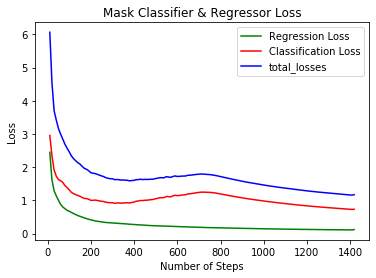

In [ ]:
# plt.figure(1)
# plt.plot(iterations, class_losses)
# plt.xlabel("iterations")
# plt.ylabel("classification loss")
# plt.title("train loss (classifier) - iteration")

# plt.figure(2)
# plt.plot(iterations, regss_losses)
# plt.xlabel("iterations")
# plt.ylabel("regression loss")
# plt.title("train loss (regressor) - iteration")

# plt.figure(3)
# plt.plot(iterations, masks_losses)
# plt.xlabel("iterations")
# plt.ylabel("mask loss")
# plt.title("train loss (mask) - iteration")

# plt.figure(4)
# plt.plot(iterations, total_losses)
# plt.xlabel("iterations")
# plt.ylabel("total loss")
# plt.title("train loss (total) - iteration")


plt.title('Mask Classifier & Regressor Loss')
plt.plot(iterations,regss_losses, color='green',label='Regression Loss')
plt.plot(iterations, class_losses, color='red',label = 'Classification Loss')
plt.plot(iterations, total_losses, color='blue',label='total_losses')
plt.legend()
plt.xlabel('Number of Steps')
plt.ylabel("Loss")

plt.show()

# Test your network

Did you remember to cut out a test set? If not you really should, test on images your network has never seen.

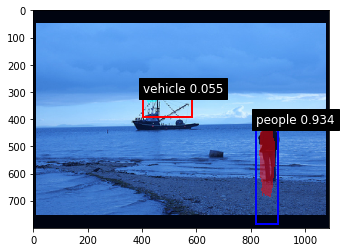

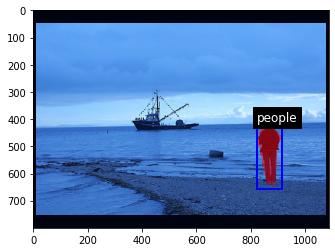

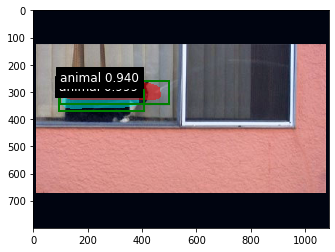

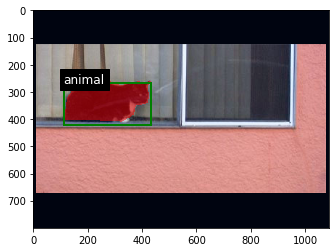

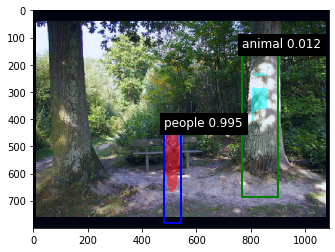

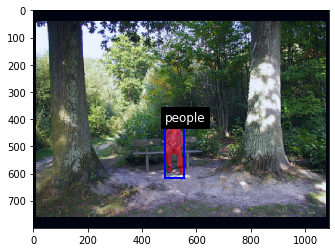

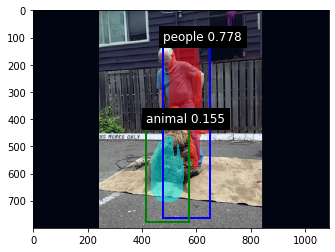

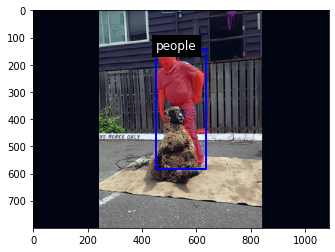

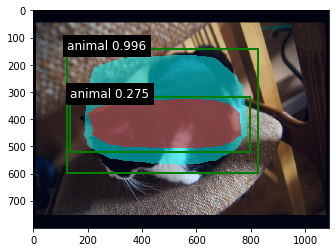

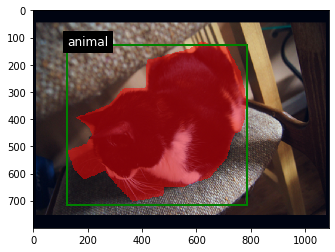

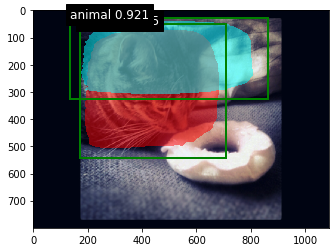

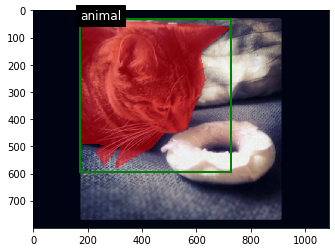

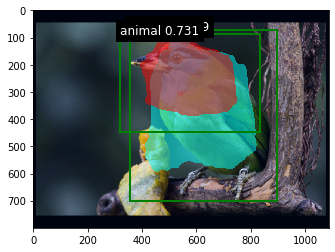

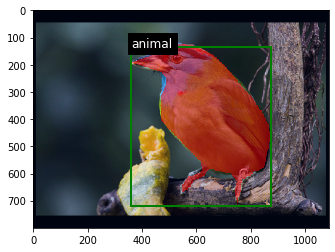

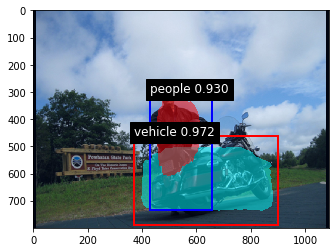

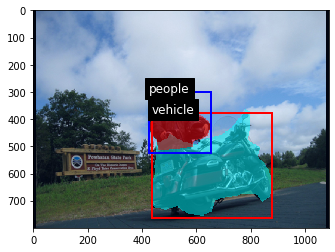

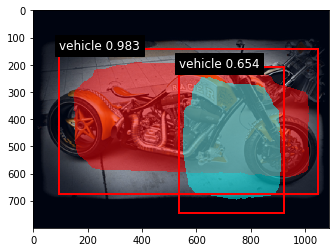

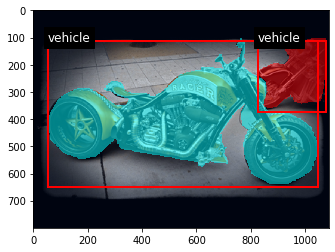

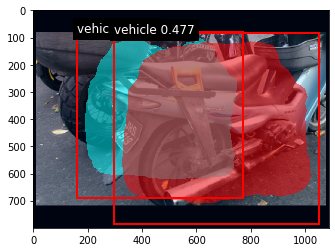

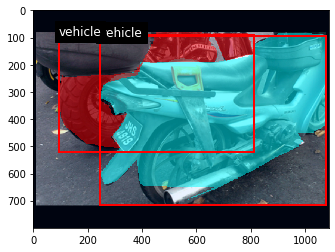

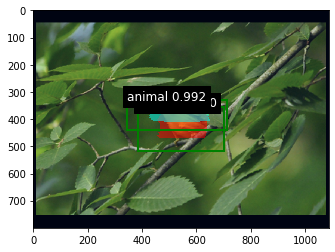

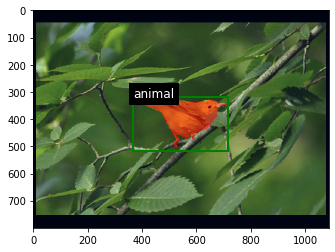

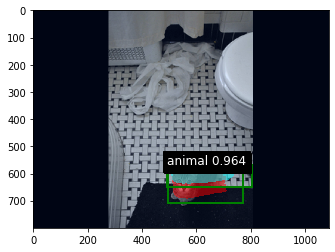

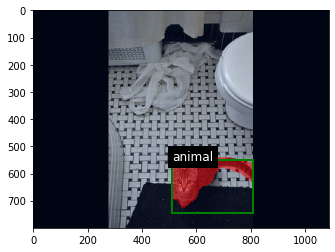

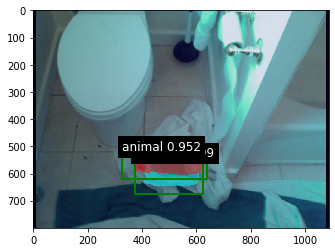

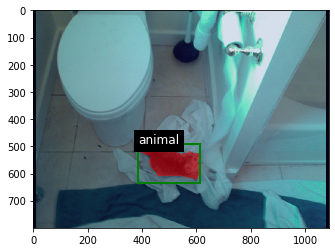

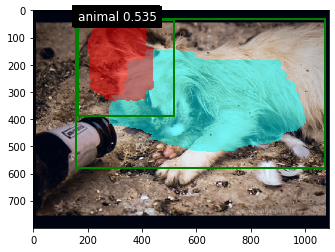

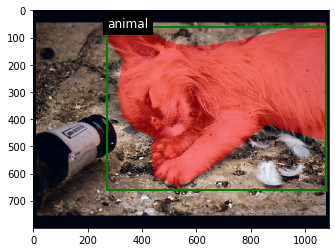

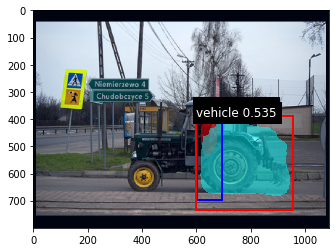

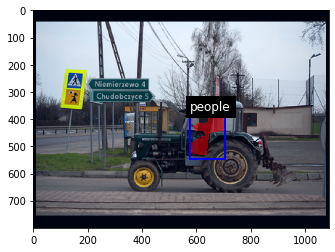

KeyboardInterrupt: ignored

In [ ]:
# Load model
box_model_val = Boxes().to(device)
mask_model_val = Masks().to(device)
box_model_val.eval()
mask_model_val.eval()

checkpoint = torch.load(MASK_MODEL_PATH)
box_model_val.load_state_dict(checkpoint['box_model'])
mask_model_val.load_state_dict(checkpoint['mask_model'])
count = 0
plot = True
with torch.no_grad():

    for i in range(int(0.7 * len(dataset)), len(dataset)):
        # if i > int(0.7 * len(dataset)):
        #     break
        data = dataset[i]
        image = data['image']
        x, target, p2, _ = prepare_data(data) 
        rpn_boxes = target[:, :4]

        # Box Model
        cls_out, reg_out = box_model_val(x)                         # cls_out: [sampled_rpns, 4], reg_out: [sampled_rpns, 4*4]
        keep = postProcess(reg_out, rpn_boxes, cls_out)             # [100, 6]: [x1,y1,x2,y2,score,class]

        # Mask model
        detections = keep[:, :4]                                    # [100, 4] in image coordinates
        roi_align = ROIAlign()
        mask_rois = roi_align(p2, [detections/4], [14,14])          # [100, 256, 14, 14]
        mask_out = mask_model_val(mask_rois)                        # [100, 4, 28, 28]

        # Take only one class
        cls = keep[:, 5].type(torch.long)
        mask_one_cls = mask_out[torch.LongTensor(range(100)), cls]  # [100, 28, 28]
        mask_one_cls = mask_one_cls.unsqueeze(1)

        # Rescale mask to image size
        x1, y1, x2, y2 = keep[:,0], keep[:,1], keep[:,2], keep[:,3]
        h = y2 - y1
        w = x2 - x1
        
        mask_total = torch.tensor([]).to(device)
        for idx in range(mask_out.shape[0]):

            if int(h[idx]) < 2 or int(w[idx]) < 2:
                continue
            mask_one = mask_one_cls[idx].unsqueeze(0)               # [1, 1, 28, 28]
            mask_rescaled = F.interpolate(mask_one, size = (int(h[idx]), int(w[idx])), mode='bilinear', align_corners=True).squeeze()   # [h, w]

            # Padding
            p2d = (int(x1[idx]), 1088-int(x1[idx])-int(w[idx]), int(y1[idx]), 800-int(y1[idx])-int(h[idx]))
            mask_padded = F.pad(mask_rescaled, p2d).unsqueeze(0)    # [800, 1088]
            mask_total = torch.cat((mask_total,mask_padded), dim=0) # [100, 800, 1088]

        # Convert to binary form
        positive_idx = torch.where(mask_total >= 0.5)
        negative_idx = torch.where(mask_total < 0.5)
        mask_total[positive_idx] = 1
        mask_total[negative_idx] = 0

        # Plot some mask with bounding boxes
        count += 1
        if plot and count <60:
            num_plot = 2
            plt.figure(i)      
            display_instance(None, plt, keep[:num_plot,4], mask_total[:num_plot], keep[:num_plot,5], image, keep[:num_plot,:4])
            plt.figure(i+1) 
            display_instance(data, plt)


[tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

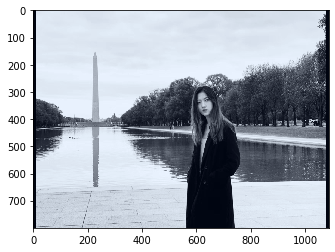

In [ ]:
"""# Inference on Customized Image

## Load and Preprocess Image
"""

from PIL import Image
# image_path = os.path.join(HOMEWORK_FOLDER, 'IMG_0442.JPG')
# image_path = os.path.join(HOMEWORK_FOLDER, 'IMG_0442.JPG')
# image_path = os.path.join(HOMEWORK_FOLDER, 'IMG_0174.JPG')
# image_path = os.path.join(HOMEWORK_FOLDER, 'IMG_0646.JPG')
# image_path = os.path.join(HOMEWORK_FOLDER, 'IMG_0651.JPG')
# image_path = os.path.join(HOMEWORK_FOLDER, 'IMG_0652.JPG')
image_path = os.path.join(HOMEWORK_FOLDER, 'IMG_0653.JPG')


# image_path = 'IMG_0442.JPG'
img = Image.open(image_path)

# Pre-process image, masks and bboxes
img_transforms = transforms.Compose([
    transforms.Resize((800, 1066)),
    transforms.Pad((11, 0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Transform image
image_transformed = img_transforms(img)         # [3, 800, 1088]

# Show the image
image = image_transformed.clone().permute(1,2,0).numpy()
image_convert = (image - image.min()) * (1/(image.max() - image.min()) * 255)
image_convert = image_convert.astype(np.uint32).copy()
plt.imshow(image_convert.astype(np.uint8))

img_list = []
img_list.append(image_transformed)
print(img_list)

In [ ]:
def prepare_data_custom(image, RPN_plot=False, ROI_plot=False):
    '''
    The mask loss Lmask is defined only on
    positive RoIs. The mask target is the intersection between
    # an RoI and its associated ground-truth mask.
    We produce one mask for each class.

    returns:
        rpn_aligned_unroll: [sampled_rpns, 256*7*7]
        rpn_result: [sampled_rpns, 9] in form of torch.tensor[x1, y1, x2, y2, label, gt_x1, gt_y1, gt_x2, gt_y2]
        p2: p2 from RPN network, [1, 256, h/4, w/4]
    '''

    image = image.unsqueeze(0).to(device)               # image as a FloatTensor with size (n_batch, 3, 800, 1088)

    #########################
    # Prepare for box model #
    ########################
    # Get feature P2
    for param in backbone.parameters():                 # freeze the weights
        param.requires_grad = False
    backout = backbone(image)
    p2 = backout[0]                                     # p2: [1, 256, h/4, w/4]

    # Get rpn output
    im_lis = ImageList(image, [(800,1088)])
    rpn.eval()
    for param in rpn.parameters():                      # freeze the weights
        param.requires_grad = False
    rpnout = rpn(im_lis,backout)                        # rpnout[0][0] is size(1000, 4)
    proposals = rpnout[0][0]

    # # Subsample assigned rpns to 128 
    # rpn_result = subsample(proposals, False)            # [sampled_rpns, 4]

    ## Visualization
    # Plot some proposals
    if RPN_plot:
        fig = plt.figure(i)   
        ax = fig.add_subplot(1, 1, 1)    
        draw_bboxes(image.squeeze().cpu(), proposals[:50], ax)

    if ROI_plot:
        n_cols = 5
        fig = plt.figure(i, figsize=(60, 60))
        ax1 = fig.add_subplot(1,n_cols,1)        
        draw_bboxes(image.squeeze().cpu(), proposals, ax1)

    # Roi Align
    rpn_boxes = proposals                               # in image coordinate
    roi_align = ROIAlign()
    aligned = roi_align(p2, [rpn_boxes/4], [7,7])       # [sampled_rpns, 256, 7, 7]
    
    ## Visualization
    # Plot some croped image after Roi Align
    if ROI_plot:
        aligned_image = roi_align(image, [rpn_boxes], [50,50])
        for j in range(2, 6):
            image_show = aligned_image[j-2].squeeze().cpu()
            image_convert = (image_show - image_show.min()) * (1/(image_show.max() - image_show.min()) * 255)
            ax2 = fig.add_subplot(1, n_cols, j)
            aisx2.imshow(image_convert.permute(1,2,0).type(torch.uint8))

    # Unroll roi output into a C*P*P vector
    N = aligned.shape[0]
    rpn_aligned_unroll = aligned.view(N, -1)            # [sampled_rpns, 256*7*7]

    return rpn_aligned_unroll, proposals                # proposals:[sampled_rpns, 4]
# pre_test_img = prepare_data_custom(img_list[0],True,True)

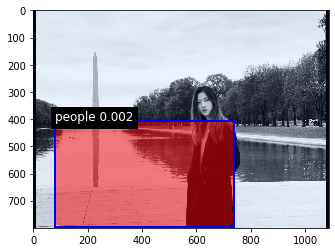

In [ ]:
# Load model
# print(img_list)
box_model_val = Boxes().to(device)
mask_model_val = Masks().to(device)
box_model_val.eval()
mask_model_val.eval()

checkpoint = torch.load(MASK_MODEL_PATH)
box_model_val.load_state_dict(checkpoint['box_model'])
mask_model_val.load_state_dict(checkpoint['mask_model'])
count = 0
plot = True
with torch.no_grad():

    for i, image in enumerate(img_list):

        x, rpn_result = prepare_data_custom(image) 

        # Box Model
        cls_out, reg_out = box_model_val(x)                         # cls_out: [sampled_rpns, 4], reg_out: [sampled_rpns, 4*4]
        keep = postProcess(reg_out, rpn_result, cls_out)            # [100, 6]: [x1,y1,x2,y2,score,class]

        # Mask model
        detections = keep[:, :4]                                    # [100, 4] in image coordinates
        roi_align = ROIAlign()
        mask_rois = roi_align(p2, [detections/4], [14,14])          # [100, 256, 14, 14]
        mask_out = mask_model_val(mask_rois)                        # [100, 4, 28, 28]
        # print(mask_out)

        # Take only one class
        cls = keep[:, 5].type(torch.long)
        mask_one_cls = mask_out[torch.LongTensor(range(100)), cls]  # [100, 28, 28]
        mask_one_cls = mask_one_cls.unsqueeze(1)
        # print(mask_one_cls)
        # Rescale mask to image size
        x1, y1, x2, y2 = keep[:,0], keep[:,1], keep[:,2], keep[:,3]
        h = y2 - y1
        w = x2 - x1
        
        mask_total = torch.tensor([]).to(device)
        for idx in range(mask_out.shape[0]):

            if int(h[idx]) < 2 or int(w[idx]) < 2:
                continue
            mask_one = mask_one_cls[idx].unsqueeze(0)               # [1, 1, 28, 28]
            mask_rescaled = F.interpolate(mask_one, size = (int(h[idx]), int(w[idx])), mode='bilinear', align_corners=True).squeeze()   # [h, w]

            # Padding
            p2d = (int(x1[idx]), 1088-int(x1[idx])-int(w[idx]), int(y1[idx]), 800-int(y1[idx])-int(h[idx]))
            mask_padded = F.pad(mask_rescaled, p2d).unsqueeze(0)    # [800, 1088]
            mask_total = torch.cat((mask_total,mask_padded), dim=0) # [100, 800, 1088]

        # Convert to binary form
        positive_idx = torch.where(mask_total >= 0.007)
        negative_idx = torch.where(mask_total < 0.007)
        mask_total[positive_idx] = 1
        mask_total[negative_idx] = 0

        # Plot some mask with bounding boxes
        if plot:
            num_plot = 1
            plt.figure(i)      
            display_instance(None, plt, keep[:num_plot,4], mask_total[:num_plot], keep[:num_plot,5], image, keep[:num_plot,:4])

In [ ]:
# Load model
# Tesing my Own:
box_model_val = Boxes().to(device)
mask_model_val = Masks().to(device)
box_model_val.eval()
mask_model_val.eval()

checkpoint = torch.load(MASK_MODEL_PATH)
box_model_val.load_state_dict(checkpoint['box_model'])
mask_model_val.load_state_dict(checkpoint['mask_model'])
count = 0
plot = True
with torch.no_grad():
  data = img_list[0]
  image = data
    for i in range(int(0.7 * len(dataset)), len(dataset)):
        # if i > int(0.7 * len(dataset)):
        #     break
        data = dataset[i]
        image = data['image']
        x, target, p2, _ = prepare_data(data) 
        rpn_boxes = target[:, :4]

        # Box Model
        cls_out, reg_out = box_model_val(x)                         # cls_out: [sampled_rpns, 4], reg_out: [sampled_rpns, 4*4]
        keep = postProcess(reg_out, rpn_boxes, cls_out)             # [100, 6]: [x1,y1,x2,y2,score,class]

        # Mask model
        detections = keep[:, :4]                                    # [100, 4] in image coordinates
        roi_align = ROIAlign()
        mask_rois = roi_align(p2, [detections/4], [14,14])          # [100, 256, 14, 14]
        mask_out = mask_model_val(mask_rois)                        # [100, 4, 28, 28]

        # Take only one class
        cls = keep[:, 5].type(torch.long)
        mask_one_cls = mask_out[torch.LongTensor(range(100)), cls]  # [100, 28, 28]
        mask_one_cls = mask_one_cls.unsqueeze(1)

        # Rescale mask to image size
        x1, y1, x2, y2 = keep[:,0], keep[:,1], keep[:,2], keep[:,3]
        h = y2 - y1
        w = x2 - x1
        
        mask_total = torch.tensor([]).to(device)
        for idx in range(mask_out.shape[0]):

            if int(h[idx]) < 2 or int(w[idx]) < 2:
                continue
            mask_one = mask_one_cls[idx].unsqueeze(0)               # [1, 1, 28, 28]
            mask_rescaled = F.interpolate(mask_one, size = (int(h[idx]), int(w[idx])), mode='bilinear', align_corners=True).squeeze()   # [h, w]

            # Padding
            p2d = (int(x1[idx]), 1088-int(x1[idx])-int(w[idx]), int(y1[idx]), 800-int(y1[idx])-int(h[idx]))
            mask_padded = F.pad(mask_rescaled, p2d).unsqueeze(0)    # [800, 1088]
            mask_total = torch.cat((mask_total,mask_padded), dim=0) # [100, 800, 1088]

        # Convert to binary form
        positive_idx = torch.where(mask_total >= 0.5)
        negative_idx = torch.where(mask_total < 0.5)
        mask_total[positive_idx] = 1
        mask_total[negative_idx] = 0

        # Plot some mask with bounding boxes
        count += 1
        if plot and count <60:
            num_plot = 2
            plt.figure(i)      
            display_instance(None, plt, keep[:num_plot,4], mask_total[:num_plot], keep[:num_plot,5], image, keep[:num_plot,:4])
            plt.figure(i+1) 
            display_instance(data, plt)